In [1]:
import sqlite3
import pandas as pd
import filler
import trainer

# Check data quality

In [2]:
def identify_data_issues(df):
    """
    Identify duplicated timestamps, missing intervals, and 
    out-of-order rows in a time-indexed DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.
        
    Returns:
        duplicates (pd.DataFrame): Rows that contain duplicate timestamps.
        missing_intervals (pd.DatetimeIndex): Start points of intervals where data is missing.
        is_unordered (bool): True if the data is not strictly time-ordered.
    """
    # Ensure 'Time' is a datetime column
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    
    # Check for any NaT (Not a Time) conversions which indicate invalid timestamps
    if df['Time'].isnull().any():
        raise ValueError("Some timestamps could not be converted to datetime.")
    
    # Check if the data is ordered by 'Time'. If not, sort it.
    if not df['Time'].is_monotonic_increasing:
        is_unordered = True
        df = df.sort_values('Time').reset_index(drop=True)
    else:
        is_unordered = False
    
    # Identify duplicates
    duplicates = df[df.duplicated(subset='Time', keep=False)]

    # Identify missing intervals
    # Calculate the difference between consecutive rows
    time_diffs = df['Time'].diff().dropna()
    # Any gap larger than 1 minute indicates missing intervals
    missing_intervals = time_diffs[time_diffs > pd.Timedelta('1min')]

    return duplicates, missing_intervals, is_unordered

# Example usage:
df = filler.read_data_from_table("ethusd")  # Assuming you have a function that reads from SQLite
duplicates, missing_intervals, is_unordered = identify_data_issues(df)
print("Duplicates:\n", duplicates)
print("Missing intervals:\n", missing_intervals)
print("Data is unordered:", is_unordered)


Duplicates:
 Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume]
Index: []
Missing intervals:
 Series([], Name: Time, dtype: timedelta64[ns])
Data is unordered: False


# See database

In [3]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM predictions 
        WHERE timestamp > '2025-01-07 01:00:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change
491,2025-01-07 14:10:00,3637.90,3635.975830,-0.052892
490,2025-01-07 14:11:00,3636.15,3627.578857,-0.235720
489,2025-01-07 14:12:00,3633.40,3629.776611,-0.099724
488,2025-01-07 14:13:00,3630.81,3627.145996,-0.100914
487,2025-01-07 14:14:00,3631.57,3628.337158,-0.089021
...,...,...,...,...
4,2025-01-08 14:25:00,3361.17,3343.440674,-0.527475
3,2025-01-08 14:26:00,3363.82,3335.092773,-0.854006
2,2025-01-08 14:27:00,3361.17,3345.866943,-0.455290
1,2025-01-08 14:28:00,3363.51,3344.889404,-0.553606


In [4]:

def load_data():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM ethusd 
        WHERE Time > '2025-01-07 01:00:00'
        ORDER BY Time DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('Time')

data = load_data()
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()

data

,Time,Open,High,Low,Close,Volume
2249,2025-01-07 01:01:00,3677.03,3677.04,3673.18,3673.18,66.9639
2248,2025-01-07 01:02:00,3673.18,3673.18,3669.43,3669.81,57.0067
2247,2025-01-07 01:03:00,3669.81,3670.37,3664.74,3664.75,64.9421
2246,2025-01-07 01:04:00,3664.75,3668.80,3664.75,3668.13,55.8914
2245,2025-01-07 01:05:00,3668.13,3668.13,3665.95,3667.10,81.8599
...,...,...,...,...,...,...
4,2025-01-08 14:26:00,3363.70,3364.58,3363.70,3363.82,21.4476
3,2025-01-08 14:27:00,3360.91,3361.17,3359.87,3361.17,30.1220
2,2025-01-08 14:28:00,3363.51,3363.51,3363.50,3363.51,39.7448
1,2025-01-08 14:29:00,3362.36,3362.36,3362.14,3362.15,50.0723


In [5]:
# Convert to datetime if not already
preds['timestamp'] = pd.to_datetime(preds['timestamp'])
data['Time'] = pd.to_datetime(data['Time'])

# Create a new column in preds for the join key: timestamp minus 60 minutes
preds['timestamp_minus_60'] = preds['timestamp'] - pd.Timedelta(minutes=60)

# Perform a left merge, matching preds.timestamp_minus_60 to data.Time
merged_df = preds.merge(
    data[['Time', 'Close']],            # Select only the columns we need from data
    how='left',
    left_on='timestamp_minus_60',
    right_on='Time'
)

# The merged_df now contains all rows from preds along with the matching 'Close' from data 
# where data.Time = preds.timestamp - 60 minutes.

# You can drop the 'Time' column (from data) and the helper column if you like:
merged_df = merged_df.drop(columns=['Time', 'timestamp_minus_60'])
merged_df['Diff_real_pred'] = 1 - merged_df['Close']/ merged_df['predicted_next_absolute_max']
merged_df


,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change,Close,Diff_real_pred
0,2025-01-07 14:10:00,3637.90,3635.975830,-0.052892,3633.14,0.000780
1,2025-01-07 14:11:00,3636.15,3627.578857,-0.235720,3632.60,-0.001384
2,2025-01-07 14:12:00,3633.40,3629.776611,-0.099724,3634.07,-0.001183
3,2025-01-07 14:13:00,3630.81,3627.145996,-0.100914,3635.86,-0.002402
4,2025-01-07 14:14:00,3631.57,3628.337158,-0.089021,3634.70,-0.001754
...,...,...,...,...,...,...
487,2025-01-08 14:25:00,3361.17,3343.440674,-0.527475,3364.00,-0.006149
488,2025-01-08 14:26:00,3363.82,3335.092773,-0.854006,3365.51,-0.009120
489,2025-01-08 14:27:00,3361.17,3345.866943,-0.455290,3364.08,-0.005443
490,2025-01-08 14:28:00,3363.51,3344.889404,-0.553606,3363.17,-0.005465


In [6]:
print(merged_df['Diff_real_pred'].max())
print(merged_df['predicted_percentage_change'].max())

0.009492247045575275
0.7649711034703799


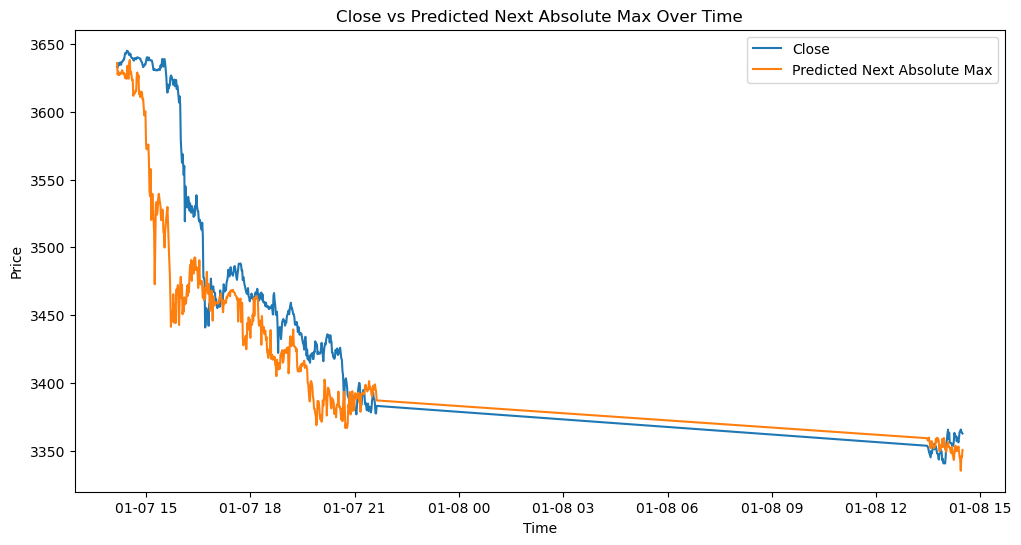

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='timestamp', y='Close', label='Close')
sns.lineplot(data=merged_df, x='timestamp', y='predicted_next_absolute_max', label='Predicted Next Absolute Max')

plt.title("Close vs Predicted Next Absolute Max Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


# Run trainer

In [2]:
from trainer import train_model

# Custom hyperparameters
custom_hyperparameters = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "tree_method": 'hist',
}

train_model(hyperparameters=custom_hyperparameters)

Starting model training...
Model training completed and model saved.
